## Title


### Load Libraries

In [1]:
library(tidyverse)
library(tidymodels)
library(cleandata)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

### Dataset and Splitting

In [2]:
#load dataset and convert categorical variables from character to factor
data <- read.csv('data/ObesityDataSet_raw_and_data_sinthetic.csv') %>%
        mutate_if(is.character,as.factor)
head(data)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,Female,21,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
2,Female,21,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
3,Male,23,1.80,77.0,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
4,Male,27,1.80,87.0,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
5,Male,22,1.78,89.8,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II
6,Male,29,1.62,53.0,no,yes,2,3,Sometimes,no,2,no,0,0,Sometimes,Automobile,Normal_Weight


In [3]:
#set seed for reproducibility
set.seed(123)

#split the data into training and testing set with 80% being in the train set, stratified sampling based on target variable
df_split <- data %>% initial_split(prop = 0.8, strata = NObeyesdad)

train_df <- training(df_split)
test_df <- testing(df_split)

### EDA

In [4]:
#print the number of missing values in the data
print(sum(is.na(train_df)))

[1] 0


In [5]:
summary(train_df['NObeyesdad'])

               NObeyesdad 
 Insufficient_Weight:217  
 Normal_Weight      :229  
 Obesity_Type_I     :280  
 Obesity_Type_II    :237  
 Obesity_Type_III   :259  
 Overweight_Level_I :232  
 Overweight_Level_II:232  

From the summary, we have a fairly equal number of observations of each of the categories for our target variable. There's no need to take further steps to deal with data imbalance.

To select features that are most appropriate and effective in predicting our target variable, we'll look at the correlation matrix of the variables. First, we will want to encode the categorical variables. We'll apply ordinal encoder for variables CAEC, CALC and target variable, one-hot encoder for MTRANS and binary encoder for the variables with reponses "yes" and "no."

In [6]:
unique(train_df["CAEC"])

,CAEC
,<fct>
60,Sometimes
77,no
98,Frequently
391,Always


In [7]:
unique(train_df["CALC"])

,CALC
,<fct>
60,no
98,Sometimes
340,Frequently


In [8]:
unique(train_df['MTRANS'])

,MTRANS
,<fct>
60,Public_Transportation
84,Walking
421,Automobile
7,Motorbike
74,Bike


In [9]:
#specify variables for encoding and corresponding orders for ordinal values
bin_vars <- c("Gender","family_history_with_overweight","FAVC","SMOKE","SCC")
levels_CAEC <- c("no","Sometimes","Frequently","Always")
levels_CALC <- c("no","Sometimes","Frequently")
levels_MTRANS <- c("Walking","Bike","Public_Transportation","Motorbike","Automobile")
levels_target <- c("Insufficient_Weight","Normal_Weight","Overweight_Level_I","Overweight_Level_II","Obesity_Type_I",
                   "Obesity_Type_II","Obesity_Type_III")

In [10]:
#Create a copy of the trainining set for setting up correlation matrix
corr_df <- train_df

#Binary encoding
corr_df[bin_vars] <- encode_binary(corr_df[bin_vars], out.int = TRUE, full_print=FALSE)

# Ordinal encoding
corr_df['CAEC'] <- encode_ordinal(corr_df['CAEC'], order = levels_CAEC, out.int=TRUE, full_print=FALSE)
corr_df['CALC'] <- encode_ordinal(corr_df['CALC'], order = levels_CALC, out.int=TRUE, full_print=FALSE)
corr_df['MTRANS'] <- encode_ordinal(corr_df['MTRANS'], order = levels_MTRANS, out.int=TRUE, full_print=FALSE)
corr_df['NObeyesdad'] <- encode_ordinal(corr_df['CAEC'], order = levels_target, out.int=TRUE, full_print=FALSE)


coded 5 cols 
coded 1 cols 4 levels 
coded 1 cols 3 levels 
coded 1 cols 5 levels 
coded 1 cols 7 levels 


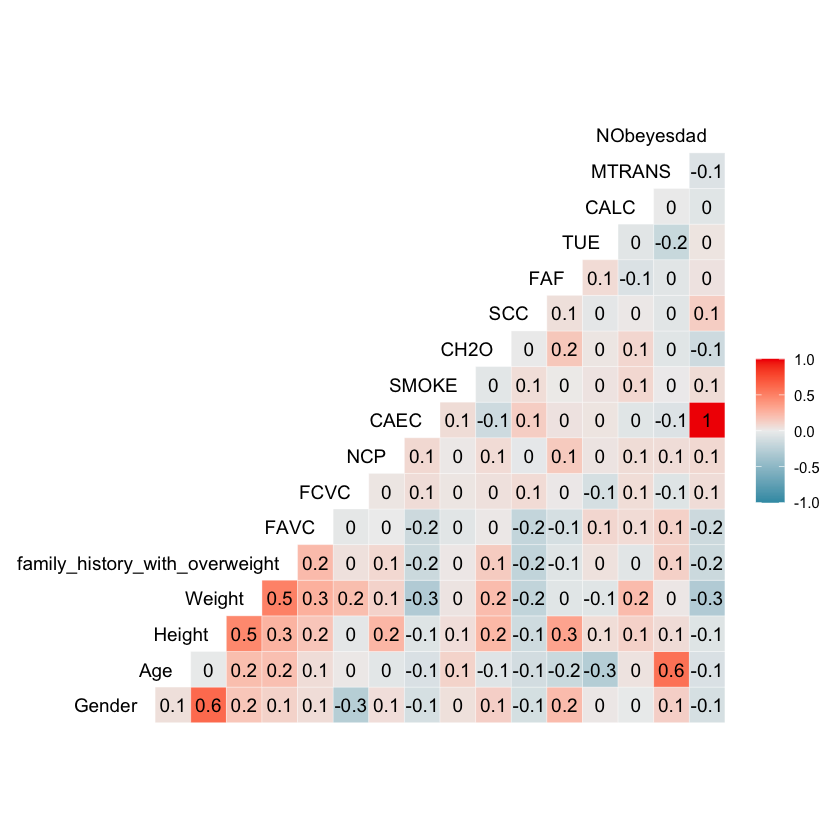

In [11]:
corr_matrix <- ggcorr(corr_df, hjust=1, size=4, label = TRUE, layout.exp = 3)
corr_matrix